<a href="https://colab.research.google.com/github/vadaliah/CS5260Assignment/blob/master/sklearn_FOREX_VWAP_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Forex VWAP(Volume Weighted Average Price) Solution using scikit-learn**

This notebook demonstrates Machine Learning solution to predict VWAP direction for given currency pair based on historical prices

## Problem Formulation

In this example, we will use Historical Currency price dataset provided from FOREX Tester APP, available here: https:https://forextester.com/data/datasources.

The dataset contains Hourly pricing data on EURUSD Currency Pair daily for 201804. Initial development and proof of concept is done using EURUSD curreny data but plan to extend across all major G10 Currenvy pairs.

In [2]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
%ls /eurusd.csv


/eurusd.csv


## Load Data

Here we first load the data into python using pandas and read it in as a pandas dataframe which is the format which we will use throughout the example.
fx_volume data consist of Pricing data for the hourly interval
*   CurrencyPair Ticker
*   BUSINESSDATE AS DTYYYYMMDD
*   HOUR as TIME
*   OPEN PRICE
*   HIGH PRICE
*   LOW PRICE
*   CLOSING PRICE
*   VOLUME


In [4]:
fx_volume = pd.read_csv("/eurusd.csv")
display(fx_volume.head())
fx_volume.info()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,EURUSD,20180401,21:00,1.23199,1.23230,1.23165,1.23204,469600000
1,EURUSD,20180401,22:00,1.23204,1.23217,1.23132,1.23172,4095050000
2,EURUSD,20180401,23:00,1.23172,1.23206,1.23124,1.23125,3291760001
3,EURUSD,20180402,00:00,1.23127,1.23217,1.23107,1.23217,5418240002
4,EURUSD,20180402,01:00,1.23219,1.23282,1.23214,1.23263,4164520003


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <TICKER>      507 non-null    object 
 1   <DTYYYYMMDD>  507 non-null    int64  
 2   <TIME>        507 non-null    object 
 3   <OPEN>        507 non-null    float64
 4   <HIGH>        507 non-null    float64
 5   <LOW>         507 non-null    float64
 6   <CLOSE>       507 non-null    float64
 7   <VOL>         507 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 31.8+ KB


VWAP represents Volume Weighted Average Price
Computation entails:
 
1.   avg_price as average of High,Low,Open and Close by currencypair
2.   PV as avg_price*volume




In [5]:
fx_volume['<AVG_PRICE>'] = (fx_volume['<HIGH>'] + fx_volume['<LOW>'] + fx_volume['<CLOSE>'] + fx_volume['<OPEN>'])/4 
fx_volume['<PV>'] = fx_volume['<VOL>'] * fx_volume['<AVG_PRICE>'] 
display(fx_volume.head())
fx_volume.info()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<AVG_PRICE>,<PV>
0,EURUSD,20180401,21:00,1.23199,1.23230,1.23165,1.23204,469600000,1.231995,5.785449e+08
1,EURUSD,20180401,22:00,1.23204,1.23217,1.23132,1.23172,4095050000,1.231813,5.044334e+09
2,EURUSD,20180401,23:00,1.23172,1.23206,1.23124,1.23125,3291760001,1.231567,4.054025e+09
3,EURUSD,20180402,00:00,1.23127,1.23217,1.23107,1.23217,5418240002,1.231670,6.673484e+09
4,EURUSD,20180402,01:00,1.23219,1.23282,1.23214,1.23263,4164520003,1.232445,5.132542e+09


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <TICKER>      507 non-null    object 
 1   <DTYYYYMMDD>  507 non-null    int64  
 2   <TIME>        507 non-null    object 
 3   <OPEN>        507 non-null    float64
 4   <HIGH>        507 non-null    float64
 5   <LOW>         507 non-null    float64
 6   <CLOSE>       507 non-null    float64
 7   <VOL>         507 non-null    int64  
 8   <AVG_PRICE>   507 non-null    float64
 9   <PV>          507 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 39.7+ KB


Model computation entails 
1. cumulative PV as sum of PV across currency pair
2. Count of number of records
VWAP price can be computed as cumulative_PV/count
VWAP direction can be computed by comparing current price against VWAP 


In [6]:
grouped = fx_volume['<PV>'].groupby(fx_volume['<TICKER>']).agg(['sum','count'])
display(grouped.head())

,sum,count
<TICKER>,,
EURUSD,5.967096e+12,507


In [ ]:
fx_volume.isna().sum()

<TICKER>        0
<DTYYYYMMDD>    0
<TIME>          0
<OPEN>          0
<HIGH>          0
<LOW>           0
<CLOSE>         0
<VOL>           0
<AVG_PRICE>     0
<PV>            0
dtype: int64

## Data cleaning and EDA

We can now explore our data. We leave this exercise to the reader. For now, we can observe that there are a few NA values which will likely need imputation. We'll wait for this step so that we can put it within our training loop. For now, we'll just drop all of the sex NAs out of the dataframe.

In [7]:
fx_volume = fx_volume.dropna(subset=['<VOL>'])
fx_volume.shape

(507, 10)

In [8]:
class_column = '<DTYYYYMMDD>'
random_seed = 325

X_train, X_test, y_train, y_test = train_test_split(fx_volume.drop(columns=class_column), fx_volume[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=fx_volume[class_column])

Quick sanity check to make sure that everything seems correct:

In [9]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (380, 9)


,<TICKER>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<AVG_PRICE>,<PV>
81,EURUSD,06:00,1.22751,1.22755,1.22586,1.22630,11351649998,1.226805,1.392626e+10
495,EURUSD,12:00,1.20770,1.20896,1.20722,1.20872,14196780001,1.208150,1.715184e+10
207,EURUSD,12:00,1.23209,1.23275,1.23120,1.23155,17497599999,1.231898,2.155525e+10
181,EURUSD,10:00,1.23781,1.23845,1.23680,1.23750,11576440002,1.237640,1.432747e+10
269,EURUSD,02:00,1.23807,1.23812,1.23757,1.23811,5157830001,1.237967,6.385226e+09



On X test: 
X test dimensions:  (127, 9)


,<TICKER>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<AVG_PRICE>,<PV>
439,EURUSD,04:00,1.21775,1.21804,1.21743,1.21755,4521290000,1.217693,5.505541e+09
31,EURUSD,04:00,1.23055,1.23099,1.23045,1.23095,3073420000,1.230735,3.782566e+09
354,EURUSD,15:00,1.22789,1.22884,1.22706,1.22816,13534470000,1.227987,1.662016e+10
94,EURUSD,19:00,1.22367,1.22382,1.22333,1.22349,5892560002,1.223577,7.210004e+09
282,EURUSD,15:00,1.23462,1.23492,1.23364,1.23447,14305280001,1.234412,1.765862e+10


In [ ]:
# X Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# X test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

## Establish the training pipeline

We can now establish the training pipeline for our models. Since this is a process we would need to repeat several times, it's good to essentially functionalize the process so we do not need to re-write redundant code. Here, we can impute some values that were missing, and encode any categorical values. Note that these pipelines will change according to the model and methodology you choose - additionally, the pipelines will also change depending on the data types of the columns in your dataset. 

In [11]:
#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [12]:
#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [13]:
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb38788b3a0>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb38788b130>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

## Cross-validation with hyperparameter tuning

Now that we have our pipelines, we can now use this as part of cross validation and hyperparameter tuning.

In [14]:
tuning_grid = {'mdl__l1_ratio' : np.linspace(0,1,5),
               'mdl__C': np.logspace(-1, 6, 3) }
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [15]:
tuning_grid

{'mdl__l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'mdl__C': array([1.00000000e-01, 3.16227766e+02, 1.00000000e+06])}

In [16]:
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot_cat',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fb38788b3a0>),
                                                                        ('num_pipe',
                                                    

In [17]:
print(grid_search.best_score_)
grid_search.best_params_

0.12105263157894737


{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mdl__C,param_mdl__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.025831,0.003192,0.008550,0.001167,0.1,0.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.0}",0.118421,0.078947,0.092105,...,0.092105,0.014414,5,0.217105,0.220395,0.200658,0.226974,0.200658,0.213158,0.010690
1,0.030723,0.004093,0.009311,0.001140,0.1,0.25,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.25}",0.131579,0.105263,0.118421,...,0.121053,0.009846,1,0.118421,0.144737,0.148026,0.118421,0.131579,0.132237,0.012552
2,0.029672,0.003766,0.008785,0.001354,0.1,0.5,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.5}",0.092105,0.092105,0.118421,...,0.107895,0.015345,2,0.105263,0.108553,0.141447,0.105263,0.105263,0.113158,0.014202
3,0.030083,0.005871,0.008321,0.000701,0.1,0.75,"{'mdl__C': 0.1, 'mdl__l1_ratio': 0.75}",0.105263,0.078947,0.092105,...,0.094737,0.009846,4,0.098684,0.108553,0.138158,0.108553,0.098684,0.110526,0.014504
4,0.060195,0.011502,0.008156,0.000455,0.1,1.0,"{'mdl__C': 0.1, 'mdl__l1_ratio': 1.0}",0.092105,0.078947,0.105263,...,0.100000,0.017848,3,0.101974,0.105263,0.138158,0.108553,0.095395,0.109868,0.014799
5,0.048783,0.003900,0.007982,0.000188,316.227766,0.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.013158,0.026316,0.026316,...,0.021053,0.006446,6,0.486842,0.470395,0.490132,0.483553,0.493421,0.484868,0.007949
6,0.115446,0.007018,0.008181,0.000751,316.227766,0.25,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.013158,0.026316,0.026316,...,0.021053,0.006446,6,0.490132,0.457237,0.493421,0.493421,0.500000,0.486842,0.015146
7,0.114208,0.007428,0.026124,0.035016,316.227766,0.5,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.013158,0.026316,0.026316,...,0.021053,0.006446,6,0.483553,0.460526,0.503289,0.490132,0.503289,0.488158,0.015789
8,0.113351,0.002274,0.009917,0.002313,316.227766,0.75,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.013158,0.026316,0.026316,...,0.021053,0.006446,6,0.503289,0.463816,0.506579,0.486842,0.496711,0.491447,0.015373
9,0.111167,0.004439,0.008041,0.000306,316.227766,1.0,"{'mdl__C': 316.22776601683796, 'mdl__l1_ratio'...",0.013158,0.026316,0.026316,...,0.021053,0.006446,6,0.493421,0.463816,0.503289,0.493421,0.496711,0.490132,0.013642


## Final fit

The final fit here is already present in the generated model due to the way we set our parameters in the grid search. If we want to look at the performance, we can do so. Here is a non-helpful description of the best model:

In [18]:
grid_search.best_estimator_

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb377478550>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                

## Variable importance

Now we assess the importance in the selected model to reveal any potential insights.

In [19]:
grid_search.classes_

array([20180401, 20180402, 20180403, 20180404, 20180405, 20180406,
       20180408, 20180409, 20180410, 20180411, 20180412, 20180413,
       20180415, 20180416, 20180417, 20180418, 20180419, 20180420,
       20180422, 20180423, 20180424, 20180425, 20180426, 20180427,
       20180429, 20180430])

## Performance metrics on test data


Here, we can see the performance of the model, which is pretty nice! We can also look into different scores specifically for more insight into the performance.

In [ ]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

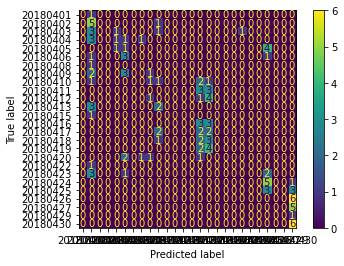

In [27]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot()

plt.show()

## Try it yourself!

Now that we've seen the power of pipelines in sklearn, let's now try implementing our own pipelines.

In [ ]:
# Try implementing a pipeline where we use median imputation for numeric columns instead of mean imputation.

#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='median')),
                               ('scale_num', StandardScaler())])

#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

With this new pipeline, now train a Random Forest model. Refer to the documentation for the parameters for the random forest classifier here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Is the performance better? 

In [ ]:
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', RandomForestClassifier())])

#visualization for steps
with config_context(display='diagram'):
    display(pipe)

Now perform cross validation and modify the n_estimators parameter to values of [100, 200,500] and max_depth parameter to values of [10,15,50] for the random forest classifier for hyperparameter tuning.

In [ ]:
tuning_grid = {'mdl__n_estimators' : [100, 200 ,500],
               'mdl__max_depth': [10, 15, 20] }
grid_search = GridSearchCV(pipe, param_grid = tuning_grid, cv = 5, return_train_score=True)

In [ ]:
tuning_grid

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_score_)
grid_search.best_params_

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.classes_

In [ ]:
vip = grid_search.best_estimator_['mdl'].feature_importances_
vip

In [ ]:
#get names in correct preproc order
cat_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[0][1].named_steps['onehot_cat'].get_feature_names()
num_names = grid_search.best_estimator_.named_steps['preproc'].transformers_[1][2]

#create df with vip info
coef_info = pd.DataFrame({'feat_names':np.hstack([cat_names, num_names]), 'vip': vip})

#get sign and magnitude information
coef_info = coef_info.assign(coef_mag = abs(coef_info['vip']),
                             coef_sign = np.sign(coef_info['vip']))

#sort and plot
coef_info = coef_info.set_index('feat_names').sort_values(by='coef_mag', ascending=False)
sns.barplot(y=coef_info.index, x='coef_mag', hue='coef_sign', data=coef_info, orient='h', dodge=False);

In [ ]:
print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

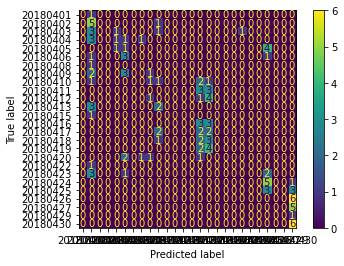

In [28]:
cm = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid_search.classes_)
disp.plot()

plt.show()